In [1]:
#Connecting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE

# Set path to your dataset
data_dir = '/content/drive/MyDrive/chest_xray (1)'

#Resizing image and configuring batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training data
train_ds = image_dataset_from_directory(
    directory=f"{data_dir}/train",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

#Load validation data
val_ds = image_dataset_from_directory(
    directory=f"{data_dir}/val",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load test data
test_ds = image_dataset_from_directory(
    directory=f"{data_dir}/test",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Prefetch batch for optimized performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 6818 files belonging to 2 classes.
Found 1172 files belonging to 2 classes.
Found 586 files belonging to 2 classes.


In [4]:
from tensorflow.keras import layers

#Implementing Data Augmentation for better generalization and to avoid overfitting
#Since it is a medical dataset, heavy data augumentation will mislead the data. Hence brightness and contrast is implemented
data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2),  # Brightness adjustment ±20%
    layers.RandomContrast(factor=0.2) ,    # Contrast adjustment ±20%
    layers.RandomZoom(0.1),
])

In [6]:
#import libraries for training the model
from tensorflow.keras import models
from tensorflow.keras.applications import EfficientNetB0 #chossing EfficientNetB0 as it is a light weight model and give better accuracy for binary image classification
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
# Base model with pretrained ImageNet weights
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze all layers initially
# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, verbose=1)

# Train (Frozen Base)
print("Training with frozen base...")
history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=6,
    callbacks=[early_stop, reduce_lr]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training with frozen base...
Epoch 1/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 1130s 5s/step - accuracy: 0.5762 - loss: 0.6798 - val_accuracy: 0.8311 - val_loss: 0.5105 - learning_rate: 1.0000e-04
Epoch 2/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 819s 4s/step - accuracy: 0.7859 - loss: 0.5118 - val_accuracy: 0.8643 - val_loss: 0.4034 - learning_rate: 1.0000e-04
Epoch 3/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 817s 4s/step - accuracy: 0.8484 - loss: 0.4211 - val_accuracy: 0.8669 - val_loss: 0.3479 - learning_rate: 1.0000e-04
Epoch 4/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 758s 3s/step - accuracy: 0.8548 - loss: 0.3787 - val_accuracy: 0.8771 - val_loss: 0.3130 - learning_rate: 1.0000e-04
Epoch 5/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 781s 4s/step - accuracy: 0.8757 - loss: 0.3393 - val_accuracy: 0.8865 - val_loss: 0.2894 - learning_rate: 1.0000e-04
Epoch 6/6
214/214 ━━━━━━━━━━━━━━━━━━━━ 782s 4s/step - accuracy: 0.8779 - loss: 0.3215 - val_accuracy: 0.8916 - val_loss: 0.2731 - learning_

In [8]:
print("Unfreezing last 20 layers for fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Re-compile with lower LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Fine-tune
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

Unfreezing last 20 layers for fine-tuning...
Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.8728 - auc: 0.9435 - loss: 0.3585 - val_accuracy: 0.9061 - val_auc: 0.9752 - val_loss: 0.2347 - learning_rate: 1.0000e-05
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 791s 4s/step - accuracy: 0.8963 - auc: 0.9597 - loss: 0.2793 - val_accuracy: 0.9206 - val_auc: 0.9811 - val_loss: 0.1986 - learning_rate: 1.0000e-05
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 811s 4s/step - accuracy: 0.9075 - auc: 0.9674 - loss: 0.2435 - val_accuracy: 0.9275 - val_auc: 0.9848 - val_loss: 0.1775 - learning_rate: 1.0000e-05
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 777s 4s/step - accuracy: 0.9201 - auc: 0.9751 - loss: 0.2117 - val_accuracy: 0.9317 - val_auc: 0.9871 - val_loss: 0.1621 - learning_rate: 1.0000e-05
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 780s 4s/step - accuracy: 0.9242 - auc: 0.9759 - loss: 0.2051 - val_accuracy: 0.9403 - val_auc: 0.9890 - val_loss: 0.1500 - learning_rate: 1.0000e-05
Epoch 6/10

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predicted probabilities
y_probs =model.predict(test_ds)
y_pred = (y_probs > 0.5).astype("int").flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step


In [10]:
# Accuracy
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))



Accuracy: 93.86%

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.95      0.94       293
   PNEUMONIA       0.95      0.92      0.94       293

    accuracy                           0.94       586
   macro avg       0.94      0.94      0.94       586
weighted avg       0.94      0.94      0.94       586



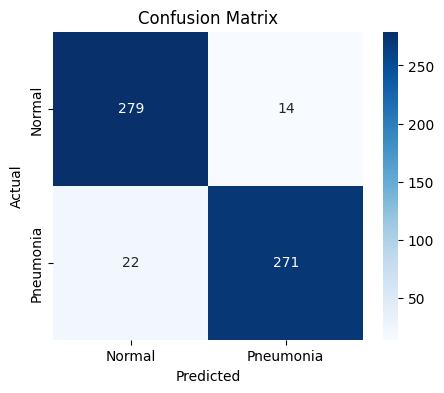

In [11]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [12]:
auc = roc_auc_score(y_true, y_probs)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.9845


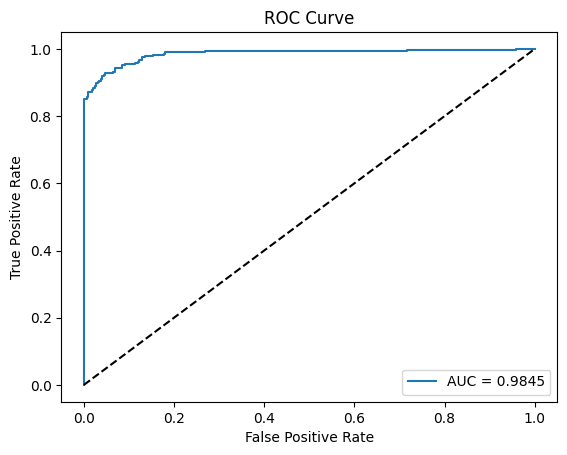

In [13]:

from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()